# Taster Workshop Data Analysis

This notebook is in combination with the UCL Data Science Society Workshop run on the 12th October 2017. We'll go through a very basic process of analyzing a dataset, introducing a basic regression model and a basic classification model. Don't worry if you don't understand the models at this point - we'll be learning more about them in the workshop series.

## Getting Started

In [46]:
import pandas as pd
from IPython.display import display, HTML
data = pd.read_csv("2017.csv")
data = data.drop(['Whisker.high','Whisker.low', 'Happiness.Rank', 'Dystopia.Residual'],axis = 1)

** Adding regional data ** 

As an exercise, I want to find out whether we can accurately classify the countries into their regions based on the data we have about the country. To do this, I found a file that contains regional information for countries on the internet and in the following cell we match up the data. 

In [4]:
countryInfo = pd.read_csv("countries.csv")
data['region'] = data['Country']
missingValues = []
for index, row in data.iterrows():
    match = countryInfo[countryInfo.name == row.Country]
    if match.empty:
        missingValues.append({'index': index, 'country': row.Country})
    else:
        data.loc[index, 'region'] = match.iloc[0]['region']
print("%d missing values" %len(missingValues))

20 missing values


13% of the countries in the dataset were not matched wihh their regional information. From a quick comparison of the datasets, we can see that there are two main reasons for this. 
- Firstly, the datasets simply have different names for the same country. We made no effort to check for this, so it's not surprising. Later on, we will learn ways of doing this, such as using regular expressions to look for matching parts of the strings.
- Secondly, different data sources will recognise different countries, for example Kosovo is not included in our regional information dataset.

In [5]:
missingRegions = {
    "United States": "Amerias",
    "United Kingdom": "Europe",
    "Taiwan Province of China": "Asia",
    "Russia": "Europe",
    "South Korea": "Asia",
    "Moldova": "Europe",
    "Bolivia": "Americas",
    "North Cyprus": "Europe",
    "Hong Kong S.A.R., China": "Asia",
    "Kosovo": "Europe",
    "Venezuela": "Americas",
    "Macedonia": "Europe",
    "Vietnam": "Asia",
    "Palestinian Territories": "Asia",
    "Iran": "Asia",
    "Congo (Brazzaville)": "Africa",
    "Congo (Kinshasa)": "Africa",
    "Ivory Coast": "Africa",
    "Syria": "Asia",
    "Tanzania": "Africa"
}

for value in missingValues:
    data.loc[value['index'], 'region'] = missingRegions[value['country']]

This leaves us with a complete dataset, which we can now do some work on.

## Getting to know the data
It's always good to have a look at the data before we start. We're going to look at three descriptions of the data: 
- A geographical plot of the data happiness index is going to be useful when we look at clustering the data by continent. (This may not load if viewing on github).
- Some descriptive statistics about the variables in the form of boxplots. Boxplots are good for visualising the distribution of a number of different variables, as they are quick to read and don't take up much space.
- A correlation plot to see how close two variables are to having a linear relationship with each other.

In [32]:
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
plotly.tools.set_credentials_file(username='pleask', api_key='5c6rwCso1rCymiK40kO5')
mapdata = dict(type = 'choropleth', 
           locations = data['Country'],
           locationmode = 'country names',
           z = data['Happiness.Score'], 
           text = data['Country'],
           colorbar = {'title':'Happiness'})
layout = dict(title = 'Global Happiness', 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
choromap3 = dict(data = [mapdata], layout=layout)
py.iplot(choromap3)

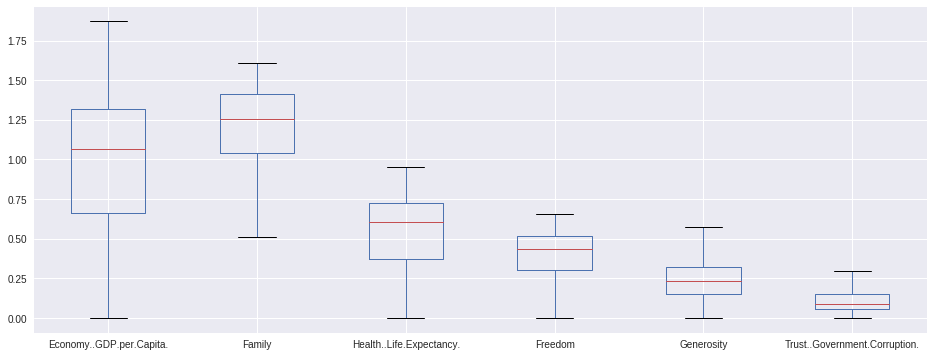

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
boxplot = data.boxplot(
    column=['Economy..GDP.per.Capita.',
        'Family',
        'Health..Life.Expectancy.',
        'Freedom',
        'Generosity',
        'Trust..Government.Corruption.'
    ]);

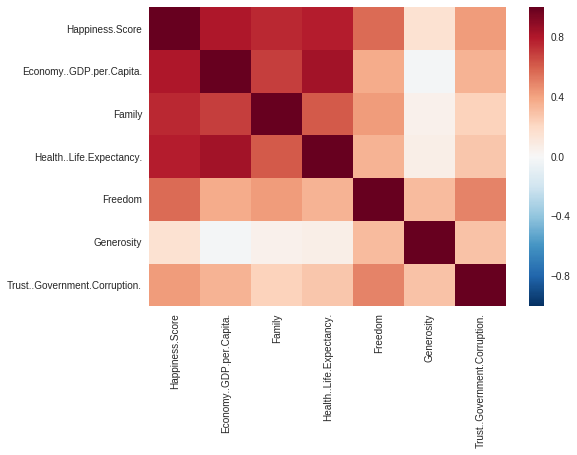

In [29]:
import seaborn as sns
sns.heatmap(data.corr());

- We can see from the world map that the happiness of a country is heavily associated with the region it is located in. The Americas have very high levels of happiness, whereas Africa has very low levels of happiness, for example.
- From the boxplots, we can see that most of the variables are not heavily skewed. There may be cause for concern in the Family and Trust Government Corruption variables.
- From the correlation plot, we can see that GDP per Capita, Family, and Health Life Expectancy are all approaching a strong positive linear relationship with happiness score. While other variables such as generosity appear to have a very low impact on happiness, this may simply mean the the relationship is not linear.

## Analysis

### Regression
Regression is the process of using independent variables (everything except happiness score) to estimate dependent variables (happiness score).

At this point, it's worth heading onto the github site (ucldata.github.io) and taking a look at the polynomial regression demo under the Taster Workshop page. Add some data, and play around fitting different order polynomials to the data, before adding more data and seeing how the values for the regressions change. Seeing it plotted in two dimensions is a lot more intuitive than just reading from a textoutput.

In [9]:
# Split the data into independent variables (Xreg), which we'll used to predict the dependent variable (yreg)
yreg = data['Happiness.Score']
Xreg = data.drop(['Country', 'Happiness.Score', 'region'], axis = 1)

We need split the data into training sets (used to train the model, in our case this means fitting the regression parameters to the data) and test sets (used to evaluate the performance of the model on unseen data).
- test_size is the proportion of the data that becomes the test set
- random_state is a value used by the random number generator that splits the dataset. We set this so that the dataset is split in the same way each time it is run.

In [10]:
from sklearn.model_selection import train_test_split
Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(Xreg, yreg, test_size = 0.3, random_state = 13)

Now we're going to fit our model using a number of different polynomial regressions to see how they each perform.

Note: sklearn does not have a specific polynomial regression built in, so we used PolynomialFeatures to create the features in the dataset, so LinearRegression acts as polynomial regression would.

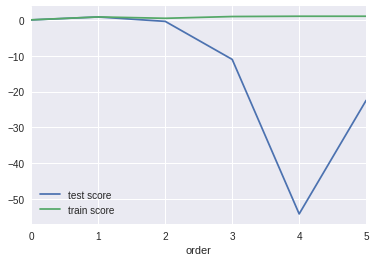

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 

scores = [] # we'll store the models here
polyRange = 5 # the highest order polynomial we will fit

for order in range(0,polyRange+1):
    reg = LinearRegression()
    poly = PolynomialFeatures(degree = order)
    Xreg_train_ = poly.fit_transform(Xreg_train)
    Xreg_test_ = poly.fit_transform(Xreg_test)
    
    reg.fit(Xreg_train_, yreg_train)
    pred = reg.predict(Xreg_test_)
    test_score = reg.score(Xreg_test_, yreg_test)
    train_score = reg.score(Xreg_train_, yreg_train)
    scores.append({'order': order, 'test score': test_score, 'train score': train_score})
scores_df = pd.DataFrame(scores)
scores_df.plot(x='order', y=['test score', 'train score']);

In this example, we can see that the only good fit to the data is a linear regression. The other order regressions that we have tried all perform worse than predicting the mean for all values (which is the case in order = 0).

### Classification

Classification is the process of identifying to which class (in our case, continent), an observation belongs. 

Go back to the github page, and look at the k-nearest neighbors demonstration on there, play about adding different classes in different groupings and see how the decision boundaries change.

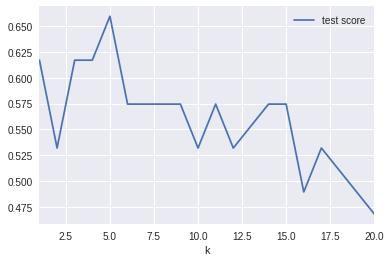

In [45]:
# Split the data into independent variables (Xcl), which we'll used to predict the dependent variable (ycl)
ycl = data['region']
Xcl = data.drop(['Country', 'Happiness.Score', 'region'], axis = 1)

# again, we split the model into training and test sets
Xcl_train, Xcl_test, ycl_train, ycl_test = train_test_split(Xcl, ycl, test_size = 0.3, random_state = 13)

from sklearn.neighbors import KNeighborsClassifier

scores = []
kRange = 20
for k in range(1, kRange + 1):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(Xcl_train, ycl_train)
    
    test_score = clf.score(Xcl_test, ycl_test)
    scores.append({'k': k, 'test score': test_score})
score_df = pd.DataFrame(scores)
score_df.plot(x='k', y='test score');

We can see for this classification problem, that as k increases beyond 5, there are no further improvements to the test score. 